# Experiment: Marginal coefficient distribution check

Experiment (Fig. 2b): compare an empirical marginal distribution of a selected Pauli coefficient against the theoretical prediction (Theorem 2) for a 3×3 2D Heisenberg model.

In [1]:
import os

# -------------------------
# User config
# -------------------------
DATA_DIR = "data"          # where .npz are stored

os.makedirs(DATA_DIR, exist_ok=True)

In [2]:
import numpy as np
import quairkit as qkit

qkit.set_dtype('complex128')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from gibbs import *

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "font.family": "STIXGeneral",
    "mathtext.fontset": "cm",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 1.4,
    "lines.markersize": 4.5,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.major.size": 3.0,
    "ytick.major.size": 3.0,
    "axes.labelpad": 2,
})

Since sampling algorithm involve random processes and measurements, we set a random seed for reproducibility.

In [5]:
qkit.set_seed(20260107)
qkit.get_seed()

20260107

## Experimental setting

In [6]:
n, hamiltonian = build_2d_heisenberg(3, 3, Jxy=0.05, Jz=0.04)
lb, si, sites = hamiltonian.decompose_with_sites()
xi = sum([abs(coef) for coef in lb])

In [7]:
error_level = 3
error = 10 ** (-error_level)

beta = 2
num_sample = 10000
num_step = int(np.ceil((xi ** 2) * (beta ** 2) / (error ** (2 / 3))))

data_tag = "run"
beta_tag = f"{float(beta):.6g}"
err_tag  = f"{float(error):.6g}"

## Compute data

In [ ]:
import os
os.makedirs("data", exist_ok=True)

list_state, sample_coef, sample_error, list_prob = algorithm1(
    n=n,
    beta=beta,
    hamiltonian=hamiltonian,
    error=error,
    num_sample=num_sample,
    num_step=num_step,
    init_state=None,
    save_dir=DATA_DIR,
    save_tag=data_tag,
    save_state=False,
    save_compressed=True,
)

In [ ]:
path = os.path.join(
    DATA_DIR,
    f"{data_tag}_b{beta_tag}_e{err_tag}_sample{int(num_sample)}_step{int(num_step)}.npz",
)

if not os.path.exists(path):
    raise FileNotFoundError(f"Data file not found: {path!r}")

This are all Pauli words you can choose to get the marginal distribution.

In [10]:
hamiltonian.pauli_words

['XIIXIIIII',
 'YIIYIIIII',
 'ZIIZIIIII',
 'XXIIIIIII',
 'YYIIIIIII',
 'ZZIIIIIII',
 'IXIIXIIII',
 'IYIIYIIII',
 'IZIIZIIII',
 'IXXIIIIII',
 'IYYIIIIII',
 'IZZIIIIII',
 'IIXIIXIII',
 'IIYIIYIII',
 'IIZIIZIII',
 'IIIXIIXII',
 'IIIYIIYII',
 'IIIZIIZII',
 'IIIXXIIII',
 'IIIYYIIII',
 'IIIZZIIII',
 'IIIIXIIXI',
 'IIIIYIIYI',
 'IIIIZIIZI',
 'IIIIXXIII',
 'IIIIYYIII',
 'IIIIZZIII',
 'IIIIIXIIX',
 'IIIIIYIIY',
 'IIIIIZIIZ',
 'IIIIIIXXI',
 'IIIIIIYYI',
 'IIIIIIZZI',
 'IIIIIIIXX',
 'IIIIIIIYY',
 'IIIIIIIZZ']

In [ ]:
term_x = "IZIIZIIII"
term_y = "IIIIYIIYI"
slice_term = "IIIYIIYII"

out = compare_terms_full_dim_mc(
    hamiltonian,
    term_x=term_x,
    term_y=term_y,
    slice_term=slice_term,
    beta=beta,
    row_key="beta2",
    error_level=error_level,
    path=path,

    # ---- empirical side ----
    max_empirical_samples=10000,

    # ---- bins / smoothing ----
    D_heat=80,
    sigma_heat=1.0,
    D_slice=160,
    sigma_slice=1.0,

    # ---- theory MC ----
    M_theory=10000,
    seed=20260120,

    # ---- cropping / log ----
    crop_zeros=True,
    crop_thresh_rel=0.0,
    crop_pad=1,
    log_color=True,
)


## Data saving and loading

In [ ]:
def save_out_npz(out, filename):
    np.savez_compressed(
        filename,

        # ---- meta ----
        meta_term_x = out["meta"]["term_x"],
        meta_term_y = out["meta"]["term_y"],
        meta_slice_term = out["meta"]["slice_term"],
        meta_ix = out["meta"]["ix"],
        meta_iy = out["meta"]["iy"],
        meta_iz = out["meta"]["iz"],
        meta_L = out["meta"]["L"],
        meta_beta = out["meta"]["beta"],
        meta_row_key = out["meta"]["row_key"],
        meta_error_level = out["meta"]["error_level"],
        meta_error = out["meta"]["error"],
        meta_xi = out["meta"]["xi"],
        meta_N = out["meta"]["N_num_step"],
        meta_M_theory = out["meta"]["M_theory"],
        meta_seed = out["meta"]["seed"],

        # ---- empirical heat ----
        emp_P = out["emp_heat"]["P_plot"],
        emp_cx = out["emp_heat"]["cX_unique"],
        emp_cy = out["emp_heat"]["cY_unique"],
        emp_x_edges = out["emp_heat"]["x_edges"],
        emp_y_edges = out["emp_heat"]["y_edges"],
        emp_extent = np.array(out["emp_heat"]["extent"], float),

        # ---- theory heat ----
        th_P = out["th_heat"]["P_plot"],
        th_cx = out["th_heat"]["cX_unique"],
        th_cy = out["th_heat"]["cY_unique"],
        th_x_edges = out["th_heat"]["x_edges"],
        th_y_edges = out["th_heat"]["y_edges"],
        th_extent = np.array(out["th_heat"]["extent"], float),

        # ---- empirical slice ----
        emp_slice_centers = out["emp_slice"]["centers"],
        emp_slice_prob = out["emp_slice"]["prob"],
        emp_slice_prob_plot = out["emp_slice"]["prob_plot"],
        emp_slice_edges = out["emp_slice"]["edges"],

        # ---- theory slice ----
        th_slice_centers = out["th_slice"]["centers"],
        th_slice_prob = out["th_slice"]["prob"],
        th_slice_prob_plot = out["th_slice"]["prob_plot"],
        th_slice_edges = out["th_slice"]["edges"],

        # ---- color scale ----
        color_log = int(out["color_scale"]["log_color"]),
        color_vmin = out["color_scale"]["vmin"],
        color_vmax = out["color_scale"]["vmax"],
    )


In [ ]:
save_out_npz(out, "data/compare_terms_full_dim_mc_data.npz")

In [14]:
def load_out_npz(filename):
    data = np.load(filename, allow_pickle=False)

    out = {
        "meta": {
            "term_x": str(data["meta_term_x"]),
            "term_y": str(data["meta_term_y"]),
            "slice_term": str(data["meta_slice_term"]),
            "ix": int(data["meta_ix"]),
            "iy": int(data["meta_iy"]),
            "iz": int(data["meta_iz"]),
            "L": int(data["meta_L"]),
            "beta": float(data["meta_beta"]),
            "row_key": str(data["meta_row_key"]),
            "error_level": int(data["meta_error_level"]),
            "error": float(data["meta_error"]),
            "xi": float(data["meta_xi"]),
            "N_num_step": int(data["meta_N"]),
            "M_theory": int(data["meta_M_theory"]),
            "seed": int(data["meta_seed"]),
        },

        "emp_heat": {
            "P_plot": data["emp_P"],
            "cX_unique": data["emp_cx"],
            "cY_unique": data["emp_cy"],
            "x_edges": data["emp_x_edges"],
            "y_edges": data["emp_y_edges"],
            "extent": data["emp_extent"].tolist(),
        },

        "th_heat": {
            "P_plot": data["th_P"],
            "cX_unique": data["th_cx"],
            "cY_unique": data["th_cy"],
            "x_edges": data["th_x_edges"],
            "y_edges": data["th_y_edges"],
            "extent": data["th_extent"].tolist(),
        },

        "emp_slice": {
            "centers": data["emp_slice_centers"],
            "prob": data["emp_slice_prob"],
            "prob_plot": data["emp_slice_prob_plot"],
            "edges": data["emp_slice_edges"],
        },

        "th_slice": {
            "centers": data["th_slice_centers"],
            "prob": data["th_slice_prob"],
            "prob_plot": data["th_slice_prob_plot"],
            "edges": data["th_slice_edges"],
        },

        "color_scale": {
            "log_color": bool(int(data["color_log"])),
            "vmin": float(data["color_vmin"]),
            "vmax": float(data["color_vmax"]),
        },
    }

    return out


We also provide saved data to save computation time.

In [ ]:
# out = load_out_npz("data/compare_terms_full_dim_mc_data.npz")

## Plot

In [16]:
emp_s = out["emp_slice"]
th_s  = out["th_slice"]
meta = out["meta"]

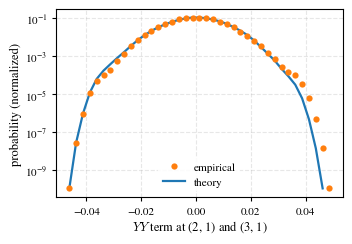

In [17]:
LEG_KW = dict(frameon=True, facecolor="white", edgecolor="none", framealpha=0.85)

fig, ax = plt.subplots(figsize=(3.375, 2.3))

# theory thick-ish, empirical dots smaller
ax.semilogy(th_s["centers"], th_s["prob_plot"], linewidth=1.6, label="theory")
ax.semilogy(emp_s["centers"], emp_s["prob_plot"],
            linestyle="None", marker="o",
            markersize=4.5, markeredgewidth=0.0,
            label="empirical")

ax.set_xlabel(r"$YY$ term at (2, 1) and (3, 1)")
ax.set_ylabel("probability (normalized)")
ax.grid(True, which="both", ls="--", alpha=0.3)

# legend order: empirical on top, theory below (without changing plot order/colors)
h, l = ax.get_legend_handles_labels()
if "empirical" in l and "theory" in l:
    order = [l.index("empirical"), l.index("theory")]
    ax.legend([h[i] for i in order], [l[i] for i in order],
              loc="lower center", **LEG_KW)
else:
    ax.legend(loc="lower center", **LEG_KW)

fig.tight_layout(pad=0.2)
plt.show()


---

In [18]:
qkit.print_info()


---------VERSION---------
quairkit: 0.5.0
torch: 2.9.1
numpy: 2.2.6
scipy: 1.15.2
matplotlib: 3.10.8
---------SYSTEM---------
Python version: 3.10.19
OS: Darwin
OS version: Darwin Kernel Version 23.5.0: Wed May  1 20:14:38 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6020
---------DEVICE---------
CPU: Apple M2 Pro
